# Final project

## Reading in data

In [1]:
# Dependencies

import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datashader as ds
import datashader.transfer_functions as tf
from datashader.mpl_ext import dsshow


/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Reading in the datasets

object_df = pd.read_parquet("./data/ObjectTable.parquet")

In [3]:
fs_df = pl.read_parquet("./data/ForcedSourceTable.parquet") # fs = forced source

For reading in the `ForcedSourceTable.parquet` I had to use the `polars` package because my kernel kept crashing when using `pandas`. Looking up the reasons for that was that my memory was to small to hold the two datasets at the same time. Solution was to read in the parquet with polars, *subsample* from it and then continue to work on the smaller dataset.

In [4]:
fs_df.shape

(48974245, 10)

This is how I calculated and wrote the new parquet

```python
# Calculate the fraction needed to sample approximately 10 million rows

fraction = 10_000_000 / len(fs_df)

# Sample rows from fs_df using the calculated fraction
sampled_df = fs_df.sample(fraction=fraction, with_replacement=False)

# Save the sampled DataFrame into a Parquet file
sampled_df.write_parquet('./data/forced_source_small.parquet')
```

After making the subsample I have written in down to the hard drive and then opened it with pandas again.

In [3]:
fs_df = pd.read_parquet("./data/forced_source_small.parquet") # using pandas to open

In [4]:
memory_usage_fs = fs_df.memory_usage(deep=True).sum() / (1024 * 1024)  # Convert bytes to megabytes
memory_usage_ob = object_df.memory_usage(deep=True).sum() / (1024 * 1024)  # Convert bytes to megabytes

print(f"Memory usage of the fs_df DataFrame: {memory_usage_fs:.2f} MB")
print(f"Memory usage of the object_df DataFrame: {memory_usage_ob:.2f} MB")

Memory usage of the fs_df DataFrame: 1144.41 MB
Memory usage of the object_df DataFrame: 1359.22 MB


Checking my memory, now the `fs_df` is much smaller and I am actually able to run it from my local machine. All these steps could and should be skipped if this is ran from a better computer or in the cloud.

In [5]:
# Checking the shapes of the datasets

print(f'Object data frame has: {object_df.shape[0]} rows and {object_df.shape[1]} columns')
print(f'Source data frame has: {fs_df.shape[0]} rows and {fs_df.shape[1]} columns')

Object data frame has: 446487 rows and 384 columns
Source data frame has: 10000000 rows and 10 columns


I have chosen ten million rows (10_000_000) completely arbitrary.

## Exploration of the data

In [6]:
fs_df.head()

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
0,0288169,53675.14,16.510782,0.018956,268599312,903052.437500,15766.415039,9440.06250,19071.64440,3
1,0807891,54385.42,20.245096,0.034762,2252074960060432,28957.867188,928.097290,1434.09375,1312.58439,3
2,0307920,53622.46,NaN,NaN,9007199397519617,-51.490921,585.781128,-1068.61610,1123.11566,0
3,1385161,54025.45,21.281990,0.254478,134250497,10723.256836,2523.821533,3650.74219,2690.71218,0
4,0332052,54423.28,19.698017,0.058117,275146375168,46213.703125,2474.262451,-1331.42188,2923.17748,0


In [4]:
# Groupby forced_source frame by objectId

fs_gp = fs_df.groupby('objectId')

In [8]:
fs_gp.head()

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
0,0288169,53675.14,16.510782,0.018956,268599312,903052.437500,15766.415039,9440.06250,19071.64440,3
1,0807891,54385.42,20.245096,0.034762,2252074960060432,28957.867188,928.097290,1434.09375,1312.58439,3
2,0307920,53622.46,NaN,NaN,9007199397519617,-51.490921,585.781128,-1068.61610,1123.11566,0
3,1385161,54025.45,21.281990,0.254478,134250497,10723.256836,2523.821533,3650.74219,2690.71218,0
4,0332052,54423.28,19.698017,0.058117,275146375168,46213.703125,2474.262451,-1331.42188,2923.17748,0
...,...,...,...,...,...,...,...,...,...,...
9995600,0706867,52225.15,21.261686,0.359201,33554961,10923.090820,4042.118652,1867.53711,6566.92531,4
9998018,0732121,54000.22,22.656988,0.739564,18014398710808649,860.222229,3774.351562,-5474.69232,4907.59247,4
9998875,0746767,52936.13,21.660078,0.364283,9007199388958721,7082.310547,3003.236084,0.00000,4247.21720,4
9999439,0736276,52936.14,22.546143,0.217828,33554449,3357.163818,722.794189,-1860.05005,1062.89707,3


In [5]:
# Select the objects that have time domain data
lc_cols = [col for col in object_df.columns if 'Periodic' in col]
td_objects = object_df.dropna(subset=lc_cols, how='all').copy()
td_objects.head(3)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,...,lcNonPeriodic[27]_g,lcNonPeriodic[27]_r,lcNonPeriodic[27]_i,lcNonPeriodic[27]_z,lcNonPeriodic[28]_u,lcNonPeriodic[28]_g,lcNonPeriodic[28]_r,lcNonPeriodic[28]_i,lcNonPeriodic[28]_z,ebv
objectId,,,,,,,,,,,,,,,,,,,,,
0271388,359.99169,0.969968,NaN,NaN,NaN,26160.979422,294519.269238,1.106956e+06,2.057265e+06,2.982015e+06,...,0.032109,0.030674,0.062576,0.324707,8.555394,2.888606,0.961880,1.213456,0.034117,0.023638
0271389,359.98092,0.652865,NaN,NaN,NaN,48849.324901,77854.298779,7.187044e+04,6.333212e+04,5.460789e+04,...,0.242187,0.034497,0.210657,0.145120,4.915713,0.018316,1.949530,0.051217,0.686231,0.027264
0271390,359.97467,-1.066557,14.123035,-6.600603,-0.013308,58226.877642,196208.333415,3.151411e+05,3.634721e+05,3.904259e+05,...,0.018121,0.008570,0.057029,0.042912,0.975324,5.251484,6.415285,0.447885,1.378181,0.039193


In [6]:
print(f'Number of timedomain objects: {td_objects.shape[0]}')

Number of timedomain objects: 212425


In [11]:
# get the light curve
demo_lc = fs_gp.get_group('0271388')

# put into five different bands
demo_lc_bands = {}
for i, b in enumerate('ugriz'):
    demo_lc_bands[b] = demo_lc[demo_lc['filter'] == i]

In [12]:
demo_lc_bands.keys()

dict_keys(['u', 'g', 'r', 'i', 'z'])

In [13]:
demo_lc_bands['z']

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
1153927,0271388,54056.24,15.173880,0.020351,275146375168,3151184.75,59067.210938,157446.00,77361.68606,4
1169595,0271388,54059.23,15.217060,0.075231,268468224,3028315.00,209832.843750,34576.00,215698.20577,4
1574535,0271388,54035.33,15.219377,0.017187,275213484104,3021861.25,47835.308594,28122.25,69167.27647,4
3166746,0271388,54402.32,15.216188,0.016916,275146506240,3030750.75,47218.746094,37011.75,68742.30888,4
3477816,0271388,54411.19,15.272337,0.015535,72057869402538056,2877999.25,41179.554688,-115739.50,64742.95963,4
4471519,0271388,52586.21,15.229529,0.018119,275146375168,2993738.75,49958.933594,0.00,70652.60141,4
5677188,0271388,53664.27,15.176622,0.015486,275146375168,3143233.75,44832.449219,149494.75,67125.58074,4
5937497,0271388,53669.23,15.274970,0.020438,72057869184303104,2871031.00,54043.554688,-122708.00,73597.56000,4
7752486,0271388,53700.23,15.242879,0.018166,275297370624,2957154.50,49478.410156,-36584.50,70313.64162,4
8245111,0271388,53681.27,15.306620,0.030191,275280592928,2788545.25,77541.632812,-205193.75,92242.07182,4


In [14]:
demo_lc

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
171235,0271388,53679.28,17.726406,0.021957,275171540992,2.947565e+05,5960.817383,-1426.37500,7404.82287,1
404156,0271388,54008.26,15.609518,0.014332,72057869184303104,2.071185e+06,27341.097656,-2942.87500,42780.17694,3
616107,0271388,54010.26,16.293520,0.013898,76561468811673600,1.103108e+06,14120.090820,-11043.12500,20816.04888,2
639857,0271388,52522.32,15.639399,0.030628,275146375168,2.014961e+06,56841.644531,-59167.00000,65677.85663,3
943301,0271388,54010.26,17.716831,0.019295,275146375168,2.973671e+05,5284.683105,1184.18750,6872.25827,1
...,...,...,...,...,...,...,...,...,...,...
8438354,0271388,54407.24,15.285604,0.012640,335708232,2.843046e+06,33099.582031,-150693.25000,59928.93610,4
8642992,0271388,54010.26,15.600886,0.020402,275297370112,2.087718e+06,39229.246094,13590.12500,51200.99299,3
8984996,0271388,54030.25,20.238241,0.057587,275297370624,2.809295e+04,1490.944580,2019.65820,2194.07723,0
9016903,0271388,53994.32,15.596487,0.017038,275163152896,2.096193e+06,32895.613281,22065.12500,46526.65115,3


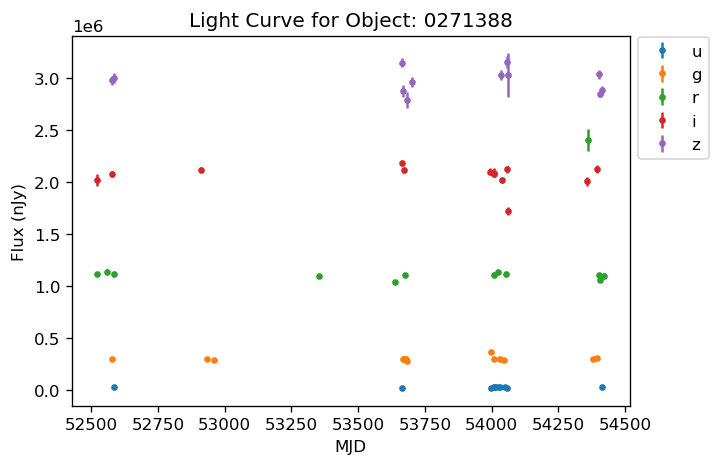

In [15]:
fig = plt.figure(figsize=(6, 4), dpi=120)
for b in demo_lc_bands:
    plt.errorbar(demo_lc_bands[b].mjd, demo_lc_bands[b].psFlux, 
                 demo_lc_bands[b].psFluxErr, fmt='.', label=b)
plt.xlabel('MJD')
plt.ylabel('Flux (nJy)')
plt.title('Light Curve for Object: 0271388')
plt.legend(bbox_to_anchor=(1, 1.02), loc=2)

## Procedure for extraction

### Write the procedure for extraction of N-number light curves in each photometric band. 

In [8]:
def extract(obj_df: pd.DataFrame, lc_df: pd.DataFrame, N: int = 100) -> pd.DataFrame:
    """
    Extract N number of light curves, including all photometric bands (u, g, r, i, z).

    Parameters:
    - obj_df (pd.DataFrame): Pandas DataFrame containing objects from which will be extraced. Provide dataframe of periodic objects.
    - lc_df (pd.DataFrame): Pandas DataFrame containing the light curves.
    - N (int, optional): Number of light curves to return. Defaults to 100 if not specified.

    Returns:
    pd.DataFrame: A sampled DataFrame containing N light curves across all photometric bands.
    """
    import random
    index_list = obj_df.index.tolist()
    obj_subsample = random.sample(index_list, N)

    light_curves = pd.DataFrame()
    
    for i in obj_subsample:
        lc = lc_df.get_group(i)
        light_curves = pd.concat([light_curves, lc], ignore_index=True)

    return light_curves


### Saving and reloading light curves

In [22]:
# Extracting light curves

curves = extract(td_objects, fs_gp, N = 5000)

In [24]:
# Save the curves to data folder

curves.to_parquet("./data/curves.parquet")

I have saved the curves as a parquet file so I could easily access them without have to run all the previous code.

In [23]:
curves

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
0,0347027,54011.36,19.656212,0.019442,275146342400,49833.703125,892.449280,-665.73047,1723.04760,1
1,0347027,54039.27,19.103132,0.020582,4503874773745664,82939.429688,1572.369263,-1871.63281,2035.02576,2
2,0347027,53270.31,19.101189,0.019527,4503874840854600,83087.960938,1494.453125,-1723.10156,1975.44302,2
3,0347027,53677.28,18.824356,0.032891,275146375168,109146.835938,3310.593994,-4823.25000,4568.88434,4
4,0347027,54029.28,18.862434,0.022197,275146342400,103522.648438,2116.614502,541.42188,3324.75040,3
...,...,...,...,...,...,...,...,...,...,...
229923,0466643,53312.19,19.663784,0.038466,268468240,49480.792969,1753.635620,187.90234,2160.48853,3
229924,0466643,52197.30,21.266714,0.119421,275179896848,10875.813477,1201.082153,-1077.27441,1671.02266,0
229925,0466643,52557.29,19.668686,0.030671,302022672,49257.921875,1391.978516,-34.96875,1878.84997,3
229926,0466643,53286.28,19.923542,0.091552,275288981520,39494.609375,3362.115723,-13325.87500,4877.53810,4


In [25]:
len(curves['objectId'].unique())

5000

```python
curves = pd.read_parquet("./data/curves.parquet")
```

This cell can be used to load in the curves if the notebook is restarted.

In [4]:
curves_u = curves[curves['filter'] == 0]
curves_g = curves[curves['filter'] == 1]
curves_r = curves[curves['filter'] == 2]
curves_i = curves[curves['filter'] == 3]
curves_z = curves[curves['filter'] == 4]

The cell above subsets the light curves based on the band.

## Visualization of the light curves

<Axes: xlabel='mjd', ylabel='psFlux'>

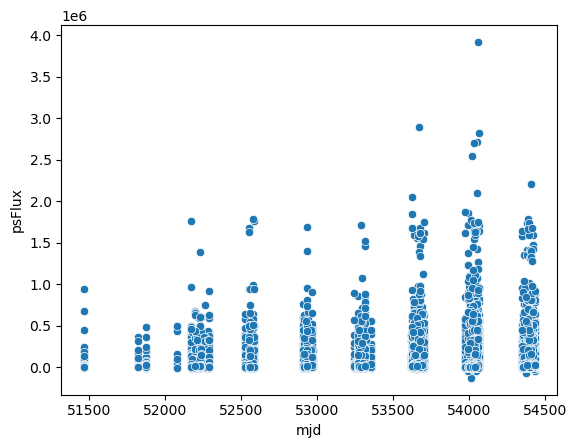

In [55]:
# Experimentation with seaborn

sns.scatterplot(data=curves_u,
                x="mjd",
                y="psFlux")

In [84]:
# Defining function for plotting


def plot_band(df: pd.DataFrame):
    """
    Plots the lightcurves from the dataframe that is filtereted by a specific band.

    Parameters:
    - df (pd.DataFrame): Pandas DataFrame containing "mjd" and "psFlux" that has been filtered on a specific band.

    Returns:
    fig that is a matplotlib figure of a

    """
    fig, ax = plt.subplots()

    def using_datashader(ax, x, y):

        df = pd.DataFrame(dict(x=x, y=y))
        dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=35,
        norm="linear",
        aspect="auto",
        ax=ax,
        )

    using_datashader(ax, df["mjd"], df['psMag'])
    ax.set_title("Light curve plot")
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    plt.show()
    return fig

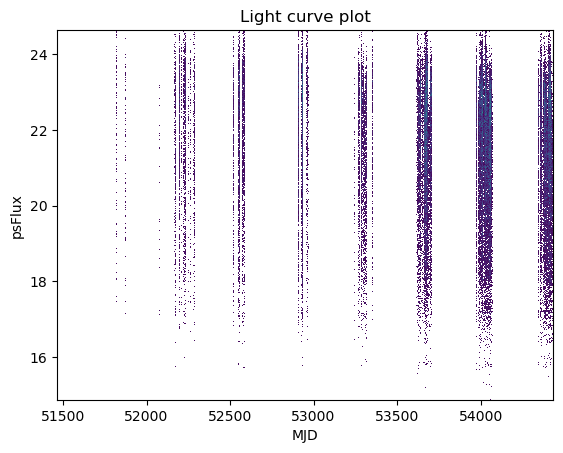

In [79]:
u_band_plot = plot_band(curves_u)

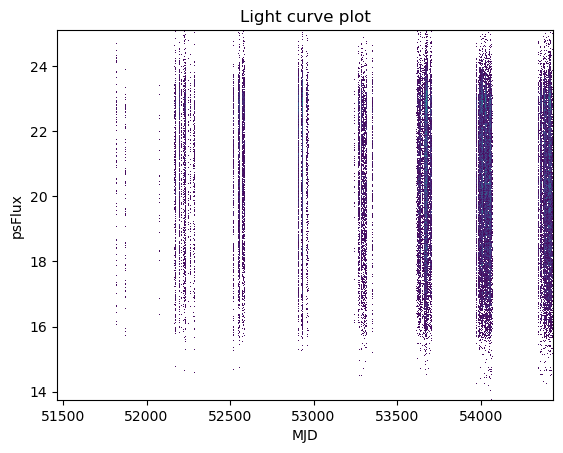

In [80]:
g_band_plot = plot_band(curves_g)

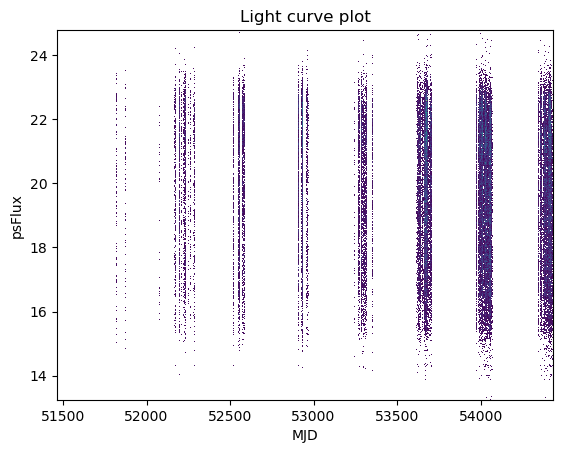

In [81]:
r_band_plot = plot_band(curves_r)

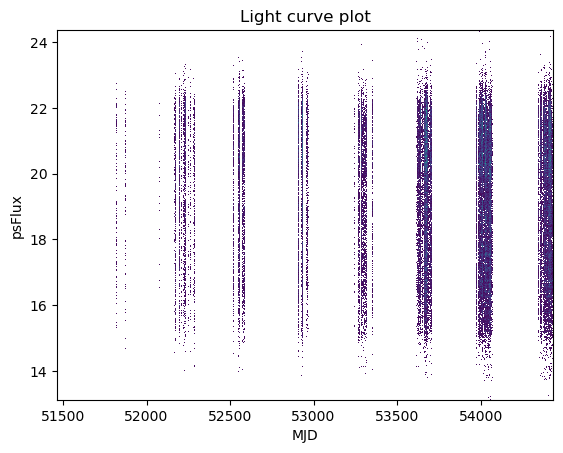

In [82]:
i_band_plot = plot_band(curves_i)

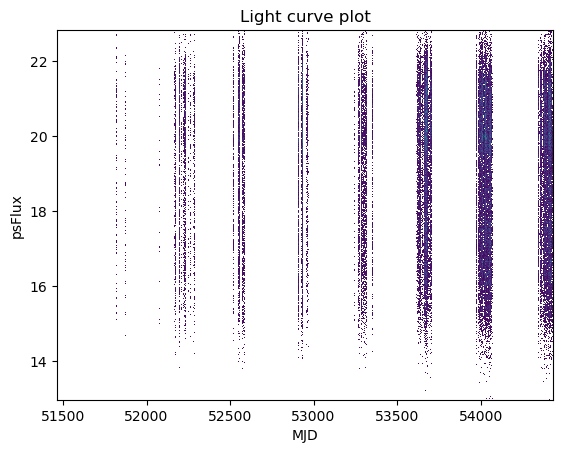

In [83]:
z_band_plot = plot_band(curves_z)

These results are not the most elegant because the data is not really easily interpeted. I have used datashader though and the execution time is rather fast.

## Creating info sheet

In [210]:
def compute_sampling_intervals(df):
    df_sorted = df.sort_values(by="mjd").reset_index(drop=True)
    df_sorted["time_diff"] = df_sorted["mjd"].diff()
    mean_sampling = df_sorted["time_diff"].mean()
    median_sampling = df_sorted["time_diff"].median()
    return mean_sampling, median_sampling

def compute_fvar(curves_df: pd.DataFrame) -> float:
    mean_flux = curves_df["psFlux"].mean()
    variance = ((curves_df["psFlux"] - mean_flux) ** 2).sum() / len(curves_df)
    mean_squared_error = curves_df["psFluxErr"] ** 2 / len(curves_df)
    
    expression_inside_sqrt = variance - mean_squared_error.mean()
    
    if expression_inside_sqrt >= 0:
        fvar = np.sqrt(expression_inside_sqrt) / mean_flux
    else:
        fvar = np.nan
    
    return fvar

def info_sheet(df):
    results = []
    
    for obj_id in df["objectId"].unique():
        subset_df = df[df["objectId"] == obj_id].copy()
        
        min_psMag = subset_df["psMag"].min()
        max_psMag = subset_df["psMag"].max()
        median_psMag = subset_df["psMag"].median()
        mean_psMag = subset_df["psMag"].mean()
        
        num_points = len(subset_df)
        mean_sampling, median_sampling = compute_sampling_intervals(subset_df)
        
        frac_var = compute_fvar(subset_df[["psFlux", "psFluxErr"]])
        
        # Recalculate time_diff after sorting by 'mjd'
        subset_df = subset_df.sort_values(by="mjd")
        subset_df["time_diff"] = subset_df["mjd"].diff()
        
        # Compute IQR for time differences
        Q1 = subset_df["time_diff"].quantile(0.25)
        Q3 = subset_df["time_diff"].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate number of gaps based on median + 1.5 * IQR
        threshold = median_sampling + 1.5 * IQR
        num_gaps = subset_df.loc[subset_df["time_diff"] > threshold, "time_diff"].count()
        
        results.append([obj_id, min_psMag, max_psMag, median_psMag, mean_psMag, 
                        num_points, mean_sampling, median_sampling, frac_var, num_gaps])
    
    stats_df = pd.DataFrame(results, columns=["objectId", "min_Mag", "max_Mag", 
                                              "median_Mag", "mean_Mag", "number_of_points", 
                                              "mean_sampling", "median_sampling", "frac_var", 
                                              "number_of_gaps"])
    
    return stats_df


For the info sheet task I had the idea to create sepparate dataframes for each of the band. I created functions to compute: mean and median sampling and a function to calculate fracional variability. I have then used them in a bigger function that looped over all idividual light curves and saved the results in a dataframe. `number_of_gaps` I calculated as the differences in sampling that were larger than median of sampling + 1.5 * IQR.

In [213]:
# Getting info sheets for every band

info_sheet_u = info_sheet(curves_u)
info_sheet_g = info_sheet(curves_g)
info_sheet_r = info_sheet(curves_r)
info_sheet_i = info_sheet(curves_i)
info_sheet_z = info_sheet(curves_z) 

# Save each DataFrame as a parquet file
info_sheet_u.to_parquet("./data/info_sheet_u.parquet")
info_sheet_g.to_parquet("./data/info_sheet_g.parquet")
info_sheet_r.to_parquet("./data/info_sheet_r.parquet")
info_sheet_i.to_parquet("./data/info_sheet_i.parquet")
info_sheet_z.to_parquet("./data/info_sheet_z.parquet")


In [214]:
info_sheet_u.head(50)

,objectId,min_Mag,max_Mag,median_Mag,mean_Mag,number_of_points,mean_sampling,median_sampling,frac_var,number_of_gaps
0,0347027,20.912300,21.253344,20.997864,21.038084,11,186.092000,42.400,0.076941,1
1,0362118,20.269297,20.747860,20.388680,20.447872,9,231.608750,177.490,0.127558,0
2,0308608,17.255688,17.550091,17.318678,17.341928,17,134.138750,12.000,0.066188,4
3,1388455,23.577635,24.382763,24.143318,24.034571,8,307.871429,22.970,-2.782408,1
4,1416590,22.166376,23.045801,22.550680,22.580616,10,244.996667,59.980,0.260415,1
5,0299839,17.405069,17.525253,17.445972,17.453173,10,165.223333,26.980,0.032398,1
6,1407195,22.434820,23.537245,22.880791,22.895798,8,262.727143,32.990,0.207427,1
7,0443246,19.153868,19.425619,19.280748,19.280846,12,199.822727,20.960,0.078374,3
8,0341153,22.423643,23.518978,22.903757,22.993849,8,316.278571,338.030,0.808607,1
9,0273714,21.046610,22.268402,21.567051,21.693264,7,171.201667,171.545,0.341022,0


## Visualizing reports

In [231]:
def plot_distribution(df: pd.DataFrame):
    """
    Plot distribution plots for all columns of the provided DataFrame using Seaborn.
    
    Parameters:
    - df (DataFrame): DataFrame containing data to plot.
    """
    
    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Set the style for the plots
    sns.set(style="whitegrid")

    # Calculate number of rows and columns for subplots
    num_cols = 2
    num_rows = (len(df.columns) + num_cols - 1) // num_cols
    
    # Create a figure and set of subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
    
    # Flatten the axes array for iteration
    axes = axes.flatten()
    
    # Iterate through each column and create a distribution plot
    for idx, column in enumerate(df.columns):
        sns.histplot(df[column].dropna(), kde=True, ax=axes[idx])  # Drop NaN values for plotting
        axes[idx].set_title(f'Distribution of {column}')
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Frequency')

    # Remove any unused subplots
    for i in range(len(df.columns), num_rows * num_cols):
        fig.delaxes(axes[i])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

    return fig

/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/damir/miniconda3/envs/bigdataastro

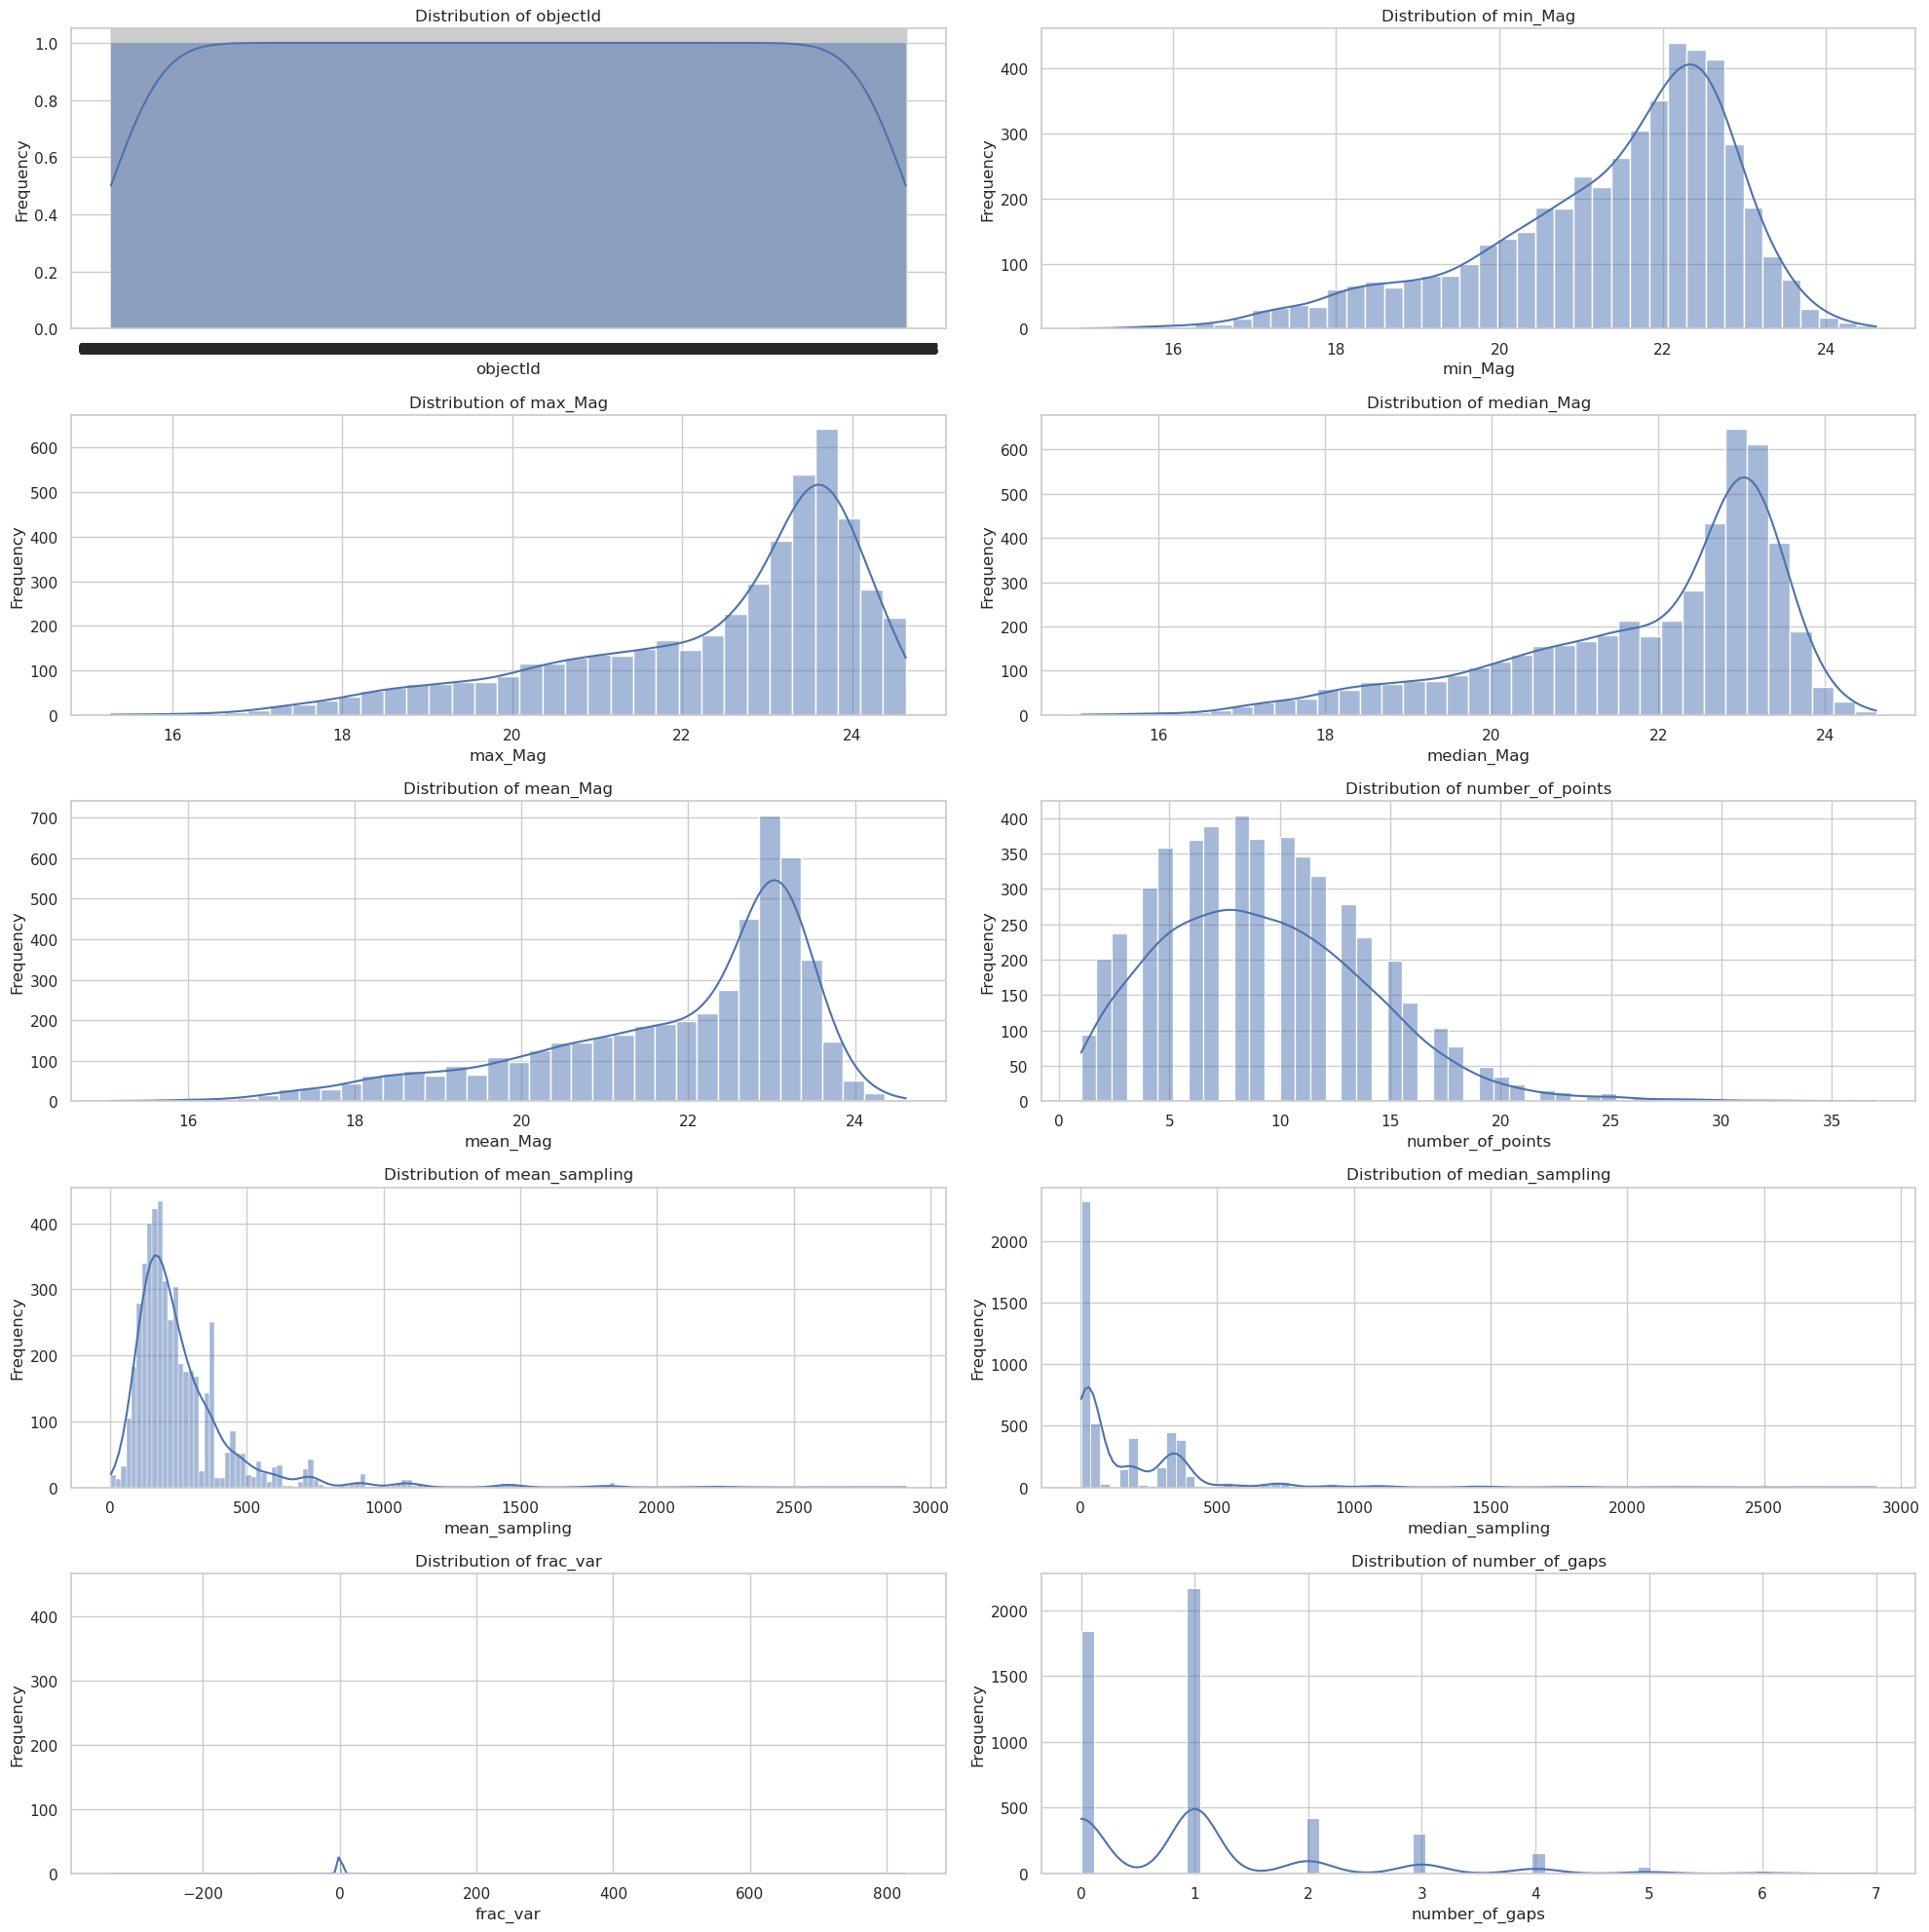

In [232]:
# Plotting the distribution of the light curves in u band

u_band_distributions = plot_distribution(info_sheet_u)

I did not manage to get around the </br>
```python
/home/damir/miniconda3/envs/bigdataastro/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
``` 

In [234]:
# Saving the u band for example

u_band_distributions.savefig('./images/u_band_distributions.png')

Figure is successfully saved and can be accessed from the `images` directory.

## Outlier metric proposition

With my lack of theoretical knowledge I could only propose several machine learning outlier detection algorithms that I am aware of and sometimes have used them in my work.

1. We could use multivariate gaussian approach to anomaly detection to check if some light curves are outliers. https://towardsdatascience.com/the-basics-of-anomaly-detection-65aff59949b7

2. It is possible to use tree based approaches also. For example `IsolationForest` https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

3. For this case when outliers are not predefined it is also possible to use OneClassSVM from `scikit-learn` https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html